In [1]:
import numpy as np
import scipy.linalg as lin
import matplotlib.pyplot as plt
import scipy.stats as sps

# Premier cas : Trajectoires avec de grandes amplitudes:

$ I_0=10, \alpha_i=10, \beta_i=5 $

On considère les poids suivants :$G_p(X_{0:p}^{(k,m)})=exp(\lambda \sum_{i=1}^{I_0}X_{p,i}^{(k,m)})$
et donc :
$\prod_{p=1}^{n-1} G_p( X^{(k,m)}_{0:p}) = \exp \Bigl( \lambda \sum_{i=1}^{I_0}\sum_{p=1}^{n-1} X^{(k,m)}_{p,i} \Bigr)$

Pour le premier cas, le signe de $\lambda$ doit être inversé.

On choisit comme valeur de $\lambda = \frac{2\hat{x}_\alpha}{T(T-1)}$

## Preset :

In [2]:
T0,T,Y=120,10,252

alpha=1-1e-4
I0=10
sigma = np.array([0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7]) #yearly std
S0=np.array([500,400,300,200,100,50,40,30,20,10])
K=np.array([510,390,310,190,90,55,35,34,17,12])
n=2*int(1e4)

coeffC=np.zeros(I0)+10
coeffP=np.zeros(I0)+5

In [3]:
def d1(to,x,y,sig):
    return np.log(x/y)/(sig*np.sqrt(to)) + sig*np.sqrt(to)/2
def d2(to,x,y,sig):
    return np.log(x/y)/(sig*np.sqrt(to)) - sig*np.sqrt(to)/2


def callPrice(S,t,K,sigma,T):
    return S*sps.norm.cdf(d1((T-t)/Y,S,K,sigma))-K*sps.norm.cdf(d2((T-t)/Y,S,K,sigma))
def putPrice(S,t,K,sigma,T):
    return K*sps.norm.cdf(d1((T-t)/Y,K,S,sigma))-S*sps.norm.cdf(d2((T-t)/Y,K,S,sigma))

In [4]:
def dCall(S,t,K,sigma,T):
  return sps.norm.cdf(d1((T-t)/Y,S,K,sigma))+sps.norm.pdf(d1((T-t)/Y,S,K,sigma))/(sigma*np.sqrt((T-t)/Y))-K*sps.norm.pdf(d2((T-t)/Y,S,K,sigma))/(sigma*np.sqrt((T-t)/Y)*S)
def hedgedCallPrice(S,t,K,sigma,T,S0):
  return callPrice(S,t,K,sigma,T)-dCall(S0,0,K,sigma,T)*S

def dPut(S,t,K,sigma,T):
  return -sps.norm.cdf(d2((T-t)/Y,K,S,sigma))+sps.norm.pdf(d2((T-t)/Y,K,S,sigma))/(sigma*np.sqrt((T-t)/Y))-K*sps.norm.pdf(d1((T-t)/Y,K,S,sigma))/(sigma*np.sqrt((T-t)/Y)*S)
def hedgedPutPrice(S,t,K,sigma,T,S0):
  return putPrice(S,t,K,sigma,T)-dPut(S0,0,K,sigma,T)*S

Définition des Greeks du modèle de Black-Scholes :

In [5]:
#Greeks
#for a call:
def thetaC(S0,K,sigma,T,T0):
    return -S0*sigma*sps.norm.pdf(d1((T0-T)/Y,S0,K,sigma))/(2*np.sqrt((T0-T)/Y))
def deltaC(S0,K,sigma,T,T0):
    return sps.norm.cdf(d1((T0-T)/Y,S0,K,sigma))
def gammaC(S0,K,sigma,T,T0):
    return sps.norm.pdf(d1((T0-T)/Y,K,S0,sigma))/(sigma*S0*np.sqrt((T0-T)/Y))

#for a put:
def thetaP(S0,K,sigma,T,T0):
    return -S0*sigma*sps.norm.pdf(d1((T0-T)/Y,S0,K,sigma))/(2*np.sqrt((T0-T)/Y))
def deltaP(S0,K,sigma,T,T0):
    return sps.norm.cdf(d1((T0-T)/Y,K,S0,sigma))-1
def gammaP(S0,K,sigma,T,T0):
    return sps.norm.pdf(d1((T0-T)/Y,K,S0,sigma))/(sigma*S0*np.sqrt((T0-T)/Y))


On définit deux quantités : $\delta$ et $\Theta$, avec $\delta$ défini pour le cas hedgé et non hedgé:

In [6]:
C=np.diag(sigma*np.sqrt(T/Y)*S0)
delta=coeffC*deltaC(S0,K,sigma,T,T0)+coeffP*deltaP(S0,K,sigma,T,T0)
deltaH=delta-coeffC*dCall(S0,0,K,sigma,T0)-coeffP*dPut(S0,0,K,sigma,T0)
Theta=np.dot(coeffC.T,thetaC(S0,K,sigma,T,T0))+np.dot(coeffP.T,thetaP(S0,K,sigma,T,T0))

Deux méthodes pour calculer des estimations grossières de la VaR utiliser ci-dessous:

In [7]:
def estimVaR(L):
  a=-Theta*T/Y
  b=-np.dot(L.T,np.dot(C.T,delta))
  
  z=sps.norm.ppf(alpha)
  return a+lin.norm(b)*z

def estimVaRHedged(L):
  a=-Theta*T/Y
  b=-np.dot(L.T,np.dot(C,deltaH))
  
  z=sps.norm.ppf(alpha)
  return a+lin.norm(b)*z

Pour exploiter la force d'optimisation de numpy, on définit les matrices suivantes: (éviter les boucles for):

In [8]:
Si=np.zeros((n,I0))
MatSigma=np.zeros((n,I0))
MatK=np.zeros((n,I0)) 
for i in range(I0):
  Si[:,i]+=S0[i]
  MatK[:,i]+=K[i]
  MatSigma[:,i]+=sigma[i]

## Cas Indépendant:

On utilise $logIncr$ comme incrément de la chaîne de Markov, afin d'appliquer l'algorithme Selection-Mutation.

$logIncr \sim \mathcal N(\mu,\Sigma)$
 avec 
 $$\Sigma =
\begin{pmatrix}
\sigma_{1}^{2} & 0 & \cdots & 0 \\
0 & \sigma_{2}^{2} & \cdots & \vdots \\
\vdots  & \vdots  & \ddots & 0  \\
0 &  \cdots & 0 & \sigma_{I_{0}}^{2}
\end{pmatrix}
$$ et $$\mu= \frac{-1}{2}\begin{pmatrix}
\sigma_{1}^{2} \\
\sigma_{2}^{2}  \\
\vdots   \\
\sigma_{I_{0}}^{2}
\end{pmatrix}$$

On estime les valeurs de la VaR dans le cas hedgé et non hedgé. On va utiliser ces deux estimations pour le calibrage du paramètres $\lambda$

In [9]:
roughEstimVaR= estimVaR(np.eye(I0))
roughEstimVaRHedged=estimVaRHedged(np.eye(I0))

print(roughEstimVaR,roughEstimVaRHedged)

318.505254924711 153.40877475100825


On initialise les incréments qui vont être communs entre la partie hedgée et non hedgée.

In [10]:
Z=np.random.normal(size=(n,T,I0)) 
logIncr=np.zeros((n,T,I0))
for t in range(T): 
  logIncr[:,t,:]=-MatSigma*MatSigma/(2*Y)+MatSigma/np.sqrt(Y)*Z[:,t,:]

### Cas non-hedgé:

#### Estimation de la VaR et la CVaR

In [11]:
X = np.zeros((n, T+1,I0))
X[:, 1,:] = logIncr[:, 0,:]

c = 1
la=2*roughEstimVaR/(T*(T-1))


for p in range(1, T):
    G = np.exp(np.sum(la * ( X[:,p,:]),axis=1))
    c*= np.mean(G)
    
    probas = G/ np.sum(G)
    indices = np.random.choice(np.arange(n), size = n, p = probas)
    X =X[indices,:,:]
    X[:,p+1,:] = X[:,p,:] + logIncr[:, p,:]

Sf=np.zeros((n,I0))
for i in range(I0):
  Sf[:,i]=S0[i]*np.exp(X[:,T,i])

(array([  12.,   40.,  328., 1474., 3782., 5855., 5207., 2604.,  638.,
          60.]),
 array([-978.58399811, -888.52674352, -798.46948893, -708.41223434,
        -618.35497976, -528.29772517, -438.24047058, -348.183216  ,
        -258.12596141, -168.06870682,  -78.01145223]),
 <a list of 10 Patch objects>)

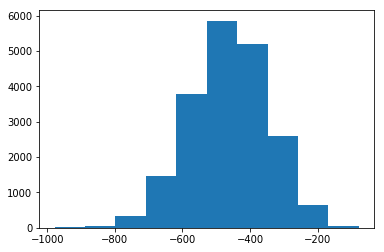

In [12]:
calls=callPrice(Sf,T,MatK,MatSigma,T0)
puts=putPrice(Sf,T,MatK,MatSigma,T0)

callInitial=callPrice(Si,0,MatK,MatSigma,T0)
putInitial=putPrice(Si,0,MatK,MatSigma,T0)

deltaCall=callInitial-calls
deltaPut=putInitial-puts

loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
plt.hist(loss)

In [13]:
A=np.zeros((n,2))

sum=np.sum(X,axis=1)
sum=np.sum(sum,axis=1) # on somme sur les deux axes correspondant aux I0 assets et aux T instants
r=c*np.exp(-la*sum)

A[:,0],A[:,1]=loss,r

print(np.mean(A[:,1]))
indexes=np.argsort(A[:,0])

A=A[indexes,:]

k,sum=n-1,0
while(sum+A[k,1]/n <1-alpha):
  sum,k=sum+A[k,1]/n,k-1

print(k) #Number of observations below VaR

VaR=A[k,0]
CVaR=np.sum(A[k+1:,0]*A[k+1:,1])/n + (1-alpha-np.sum(A[k+1:,1])/n)*A[k,0]
CVaR=CVaR/(1-alpha)

print(VaR,CVaR)

3.5180497964179825e-10


IndexError: index -20001 is out of bounds for axis 0 with size 20000

#### Convergence des estimateurs :

Cette partie de code a été commenté parce qu'elle prend beaucoup de temps à s'executer. Une deuxième version avec un tri par insertion avec une complexité de $O(nlog(n)) $ .

In [ ]:
'''
VaRvalues=[]
ESvalues=[]
A=np.zeros((n,2))
A[:,0],A[:,1]=loss,r
for i in range(10,n,10):
  B=A[:i,:i]
  indexes=np.argsort(B[:,0])

  B=B[indexes,:]
  k,sum=i-1,0
  while(sum+B[k,1]/i <1-alpha):
    sum,k=sum+B[k,1]/i,k-1

  VaRvalues.append(B[k,0])
  ES=np.sum(B[k+1:,0]*B[k+1:,1])/i + (1-alpha-np.sum(B[k+1:,1])/i)*B[k,0]
  ESvalues.append(ES/(1-alpha))
  '''
#Very time consuming method to show convergence

In [ ]:
#plt.subplot(2,1,1)
#plt.plot(np.arange(10,n,10),VaRvalues,label="Convergence du quantile empirique")

#plt.subplot(2,1,2)
#plt.plot(np.arange(10,n,10),ESvalues,label="Convergence de la CVaR")
#plt.legend(loc='best')

#### Distribution au delà de la $VaR$

In [ ]:
conditional=A[A[:,0]>VaR]
cumulativeF=np.cumsum(conditional[:,1])/(n*(1-alpha))

sc=(CVaR-VaR) 

plt.plot(conditional[:,0],sps.expon.cdf(conditional[:,0],loc=VaR,scale=sc),label='Fonction de répartition théorique')
plt.plot(conditional[:,0],cumulativeF,label='Fonction de répartition empirique')
plt.title("Comparaison entre la distribution théorique et empirique")
plt.legend(loc='best')

In [ ]:
#Kolmogrov Smirnov Test:

diff=np.abs(cumulativeF-sps.expon.cdf(conditional[:,0],loc=VaR,scale=sc))
plt.plot(conditional[:,0],diff,label="$|\widetilde{F}_n(X_{k:n})-F_\lambda(X_{k:n})|$")

plt.legend(loc='best')

In [ ]:
#Q-Q plot
th=VaR-sc*np.log(1-cumulativeF)

plt.plot(th,th,label='y=f(x)')
plt.plot(th,conditional[:,0],label='Quantile théorique vs empirique')
plt.legend(loc='best')

#### Intervalle de confiance

In [ ]:
#Estimation naive
m=int(1e2)

naiveVaR,naiveCVaR=[],[]
for i in range(m):
    Z=np.random.normal(size=(n,T,I0)) 
    logIncr2=np.zeros((n,T,I0))
    for t in range(T):
        logIncr2[:,t,:]=-MatSigma*MatSigma/(2*Y)+MatSigma/np.sqrt(Y)*Z[:,t,:]
    logS=np.cumsum(logIncr2,axis=1)
    Sf=np.zeros((n,I0))
    for j in range(I0):
        Sf[:,j]=S0[j]*np.exp(logS[:,T-1,j])
    
    calls=callPrice(Sf,T,MatK,MatSigma,T0)
    puts=putPrice(Sf,T,MatK,MatSigma,T0)

    callInitial=callPrice(Si,0,MatK,MatSigma,T0)
    putInitial=putPrice(Si,0,MatK,MatSigma,T0)

    deltaCall=callInitial-calls
    deltaPut=putInitial-puts

    loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
    sortedLoss=np.sort(loss)
    naiveVaR.append(sortedLoss[int(n*alpha)])
    CVaR=np.sum(sortedLoss[sortedLoss>naiveVaR[-1]])/(n*(1-alpha))
    naiveCVaR.append(CVaR)
    if(i%10==0):
        print(i)

In [ ]:
#Selection-Mutation

la=roughEstimVaR/(T+1)
VaR,CVaR=[],[]

for i in range(m):
    Z=np.random.normal(size=(n,T,I0)) 
    logIncr2=np.zeros((n,T,I0))
    for t in range(T): 
      logIncr2[:,t,:]=-MatSigma*MatSigma/(2*Y)+MatSigma/np.sqrt(Y)*Z[:,t,:]
    X = np.zeros((n, 2,I0))
    X[:, 1,:] = logIncr2[:, 0,:]

    c=1
    for p in range(1, T):
        G = np.exp(np.sum(la * ( X[:,1,:]  - X[:,0,:]) ,axis=1))
        c*= np.mean(G)

        probas = G/ np.sum(G)
        indices = np.random.choice(np.arange(n), size = n, p = probas)
        X[:,0,:] =X[indices, 1,:]
        X[:,1,:] = X[:,0,:] + logIncr2[:, p,:]

    Sf=np.zeros((n,I0))

    for j in range(I0):
      Sf[:,j]=S0[j]*np.exp(X[:,1,j])
    
    calls=callPrice(Sf,T,MatK,MatSigma,T0)
    puts=putPrice(Sf,T,MatK,MatSigma,T0)

    callInitial=callPrice(Si,0,MatK,MatSigma,T0)
    putInitial=putPrice(Si,0,MatK,MatSigma,T0)

    deltaCall=callInitial-calls
    deltaPut=putInitial-puts

    loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
    A=np.zeros((n,2))

    sum=np.sum(X,axis=1)
    sum=np.sum(sum,axis=1) # on somme sur les deux axes correspondant aux I0 assets et aux T instants
    r=c*np.exp(-la*sum)
    A[:,0],A[:,1]=loss,r

    indexes=np.argsort(A[:,0])
    A=A[indexes,:]

    k,sum=n-1,0
    while(sum+A[k,1]/n <1-alpha):
        sum,k=sum+A[k,1]/n,k-1

    VaR.append(A[k,0])
    cvar=np.sum(A[k+1:,0]*A[k+1:,1])/n + (1-alpha-np.sum(A[k+1:,1])/n)*A[k,0]
    CVaR.append(cvar/(1-alpha))
    if(i%10==0):
        print(i)

In [ ]:
red_square = dict(markerfacecolor='r', marker='s')
plt.boxplot([VaR,naiveVaR],bootstrap=1000,showmeans=True, flierprops=red_square,labels=('IPS VaR','Naive VaR'))

In [ ]:
plt.boxplot([CVaR,naiveCVaR],bootstrap=1000,showmeans=True, flierprops=red_square,labels=('IPS CVaR','Naive CVaR'))


### Cas Hedgé:

#### Estimation de la VaR et la CVaR

In [ ]:
X = np.zeros((n, 2,I0))
X[:, 1,:] = logIncr[:, 0,:]


c = 1
la=-roughEstimVaRHedged/(T+1)
for p in range(1, T):
    G = np.exp(np.sum(la * ( X[:,1,:]  - X[:,0,:]) ,axis=1))
    c*= np.mean(G)
    
    probas = G/ np.sum(G)
    indices = np.random.choice(np.arange(n), size = n, p = probas)
    X[:,0,:] =X[indices, 1,:]
    X[:,1,:] = X[:,0,:] + logIncr[:, p,:]

Sf=np.zeros((n,I0))

for i in range(I0):
  Sf[:,i]=S0[i]*np.exp(X[:,1,i])

In [ ]:
calls=hedgedCallPrice(Sf,T,MatK,MatSigma,T0,Si)
puts=hedgedPutPrice(Sf,T,MatK,MatSigma,T0,Si)

callInitial=hedgedCallPrice(Si,0,MatK,MatSigma,T0,Si)
putInitial=hedgedPutPrice(Si,0,MatK,MatSigma,T0,Si)

deltaCall=callInitial-calls
deltaPut=putInitial-puts

loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
plt.hist(loss)

In [ ]:
A=np.zeros((n,2))

sum=np.sum(X,axis=1)
sum=np.sum(sum,axis=1) # on somme sur les deux axes correspondant aux I0 assets et aux T instants
r=c*np.exp(-la*sum)

A[:,0],A[:,1]=loss,r
print(np.mean(A[:,1]))
indexes=np.argsort(A[:,0])

A=A[indexes,:]

k,sum=n-1,0

while(sum+A[k,1]/n <1-alpha):
  sum+=A[k,1]/n
  k-=1

print(k) #number of observation below VaR
VaR=A[k,0]
CVaR=np.sum(A[k+1:,0]*A[k+1:,1])/n + (1-alpha-np.sum(A[k+1:,1])/n)*A[k,0]
CVaR=CVaR/(1-alpha)

print(VaR,CVaR)

#### Distribution au delà de la $VaR$

In [ ]:
conditional=A[A[:,0]>VaR]
cumulativeF=np.cumsum(conditional[:,1])/(n*(1-alpha))

sc=(CVaR-VaR) 

plt.plot(conditional[:,0],sps.expon.cdf(conditional[:,0],loc=VaR,scale=sc),label='Fonction de répartition théorique')
plt.plot(conditional[:,0],cumulativeF,label='Fonction de répartition empirique')
plt.title("Comparaison entre la distribution théorique et empirique")
plt.legend(loc='best')

In [ ]:
#Kolmogrov Smirnov Test:

diff=np.abs(cumulativeF-sps.expon.cdf(conditional[:,0],loc=VaR,scale=sc))
plt.plot(conditional[:,0],diff,label="$|\widetilde{F}_n(X_{k:n})-F_\lambda(X_{k:n})|$")

plt.legend(loc='best')

In [ ]:
#Q-Q plot
th=VaR-sc*np.log(1-cumulativeF)

plt.plot(th,th,label='y=f(x)')
plt.plot(th,conditional[:,0],label='Quantile théorique vs empirique')
plt.legend(loc='best')

#### Intervalle de confiance :

In [ ]:
#Estimation naive
m=int(1e2)

naiveVaR,naiveCVaR=[],[]
for i in range(m):
    Z=np.random.normal(size=(n,T,I0)) 
    logIncr2=np.zeros((n,T,I0))
    for t in range(T):
        logIncr2[:,t,:]=-MatSigma*MatSigma/(2*Y)+MatSigma/np.sqrt(Y)*Z[:,t,:]
    logS=np.cumsum(logIncr2,axis=1)
    Sf=np.zeros((n,I0))
    for j in range(I0):
        Sf[:,j]=S0[j]*np.exp(logS[:,T-1,j])
    
    calls=hedgedCallPrice(Sf,T,MatK,MatSigma,T0,Si)
    puts=hedgedPutPrice(Sf,T,MatK,MatSigma,T0,Si)

    callInitial=hedgedCallPrice(Si,0,MatK,MatSigma,T0,Si)
    putInitial=hedgedPutPrice(Si,0,MatK,MatSigma,T0,Si)

    deltaCall=callInitial-calls
    deltaPut=putInitial-puts

    loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
    sortedLoss=np.sort(loss)
    naiveVaR.append(sortedLoss[int(n*alpha)])
    CVaR=np.sum(sortedLoss[sortedLoss>naiveVaR[-1]])/(n*(1-alpha))
    naiveCVaR.append(CVaR)
    if(i%10==0):
        print(i)

In [ ]:
#Selection-Mutation

la=roughEstimVaR/(T+1)
VaR,CVaR=[],[]

for i in range(m):
    Z=np.random.normal(size=(n,T,I0)) 
    logIncr2=np.zeros((n,T,I0))
    for t in range(T): 
      logIncr2[:,t,:]=-MatSigma*MatSigma/(2*Y)+MatSigma/np.sqrt(Y)*Z[:,t,:]
    X = np.zeros((n, 2,I0))
    X[:, 1,:] = logIncr2[:, 0,:]

    c=1
    for p in range(1, T):
        G = np.exp(np.sum(la * ( X[:,1,:]  - X[:,0,:]) ,axis=1))
        c*= np.mean(G)

        probas = G/ np.sum(G)
        indices = np.random.choice(np.arange(n), size = n, p = probas)
        X[:,0,:] =X[indices, 1,:]
        X[:,1,:] = X[:,0,:] + logIncr2[:, p,:]

    Sf=np.zeros((n,I0))

    for j in range(I0):
      Sf[:,j]=S0[j]*np.exp(X[:,1,j])
    
    calls=hedgedCallPrice(Sf,T,MatK,MatSigma,T0,Si)
    puts=hedgedPutPrice(Sf,T,MatK,MatSigma,T0,Si)

    callInitial=hedgedCallPrice(Si,0,MatK,MatSigma,T0,Si)
    putInitial=hedgedPutPrice(Si,0,MatK,MatSigma,T0,Si)

    deltaCall=callInitial-calls
    deltaPut=putInitial-puts

    loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
    A=np.zeros((n,2))

    sum=np.sum(X,axis=1)
    sum=np.sum(sum,axis=1) # on somme sur les deux axes correspondant aux I0 assets et aux T instants
    r=c*np.exp(-la*sum)
    A[:,0],A[:,1]=loss,r

    indexes=np.argsort(A[:,0])
    A=A[indexes,:]

    k,sum=n-1,0
    while(sum+A[k,1]/n <1-alpha):
        sum,k=sum+A[k,1]/n,k-1

    VaR.append(A[k,0])
    cvar=np.sum(A[k+1:,0]*A[k+1:,1])/n + (1-alpha-np.sum(A[k+1:,1])/n)*A[k,0]
    CVaR.append(cvar/(1-alpha))
    if(i%10==0):
        print(i)

In [ ]:
red_square = dict(markerfacecolor='r', marker='s')
plt.boxplot([VaR,naiveVaR],bootstrap=1000,showmeans=True, flierprops=red_square,labels=('IPS VaR','Naive VaR'))

In [ ]:
plt.boxplot([CVaR,naiveCVaR],bootstrap=1000,showmeans=True, flierprops=red_square,labels=('IPS CVaR','Naive CVaR'))


# Cas Dépendant:

 On multiplie la matrice initiale $\Sigma$ par la matrice $M$ des deux côtés et on obtient une nouvelle matrice de covariance $M^T \Sigma M$ où M est défini de la facon suivante :
 $$M =
\begin{pmatrix}
1 & \rho & \cdots & \rho \\
\rho & 1 & \cdots & \vdots \\
\vdots  & \vdots  & \ddots &\rho  \\
\rho &  \cdots & \rho & 1
\end{pmatrix}
$$

In [ ]:
rho=0.1
Cov=(1-rho)*np.eye(I0)+rho*np.ones((I0,I0)) 
L = lin.cholesky(Cov, lower=True)

In [ ]:
roughEstimVaR= estimVaR(L)
roughEstimVaRHedged=estimVaRHedged(L)

print(roughEstimVaR,roughEstimVaRHedged)

In [ ]:
Z=np.random.normal(size=(n,T,I0)) 
for t in range(T): #correlation 
  Z[:,t,:]=np.dot(L,Z[:,t,:].T).T
logIncr=np.zeros((n,T,I0))
for t in range(T): 
  logIncr[:,t,:]=-MatSigma*MatSigma/(2*Y)+MatSigma/np.sqrt(Y)*Z[:,t,:]

## Cas Non Hedgé:

In [ ]:
X = np.zeros((n, T+1,I0))
X[:, 1,:] = logIncr[:, 0,:]

c = 1
la=2*roughEstimVaRHedged/(T*(T-1))


for p in range(1, T):
    G = np.exp(np.sum(la * ( X[:,p,:]),axis=1))
    c*= np.mean(G)
    
    probas = G/ np.sum(G)
    indices = np.random.choice(np.arange(n), size = n, p = probas)
    X =X[indices,:,:]
    X[:,p+1,:] = X[:,p,:] + logIncr[:, p,:]

Sf=np.zeros((n,I0))
for i in range(I0):
  Sf[:,i]=S0[i]*np.exp(X[:,T,i])

In [ ]:
calls=callPrice(Sf,T,MatK,MatSigma,T0)
puts=putPrice(Sf,T,MatK,MatSigma,T0)

callInitial=callPrice(Si,0,MatK,MatSigma,T0)
putInitial=putPrice(Si,0,MatK,MatSigma,T0)

deltaCall=callInitial-calls
deltaPut=putInitial-puts

loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
plt.hist(loss)

In [ ]:
A=np.zeros((n,2))

sum=np.sum(X,axis=1)
sum=np.sum(sum,axis=1) # on somme sur les deux axes correspondant aux I0 assets et aux T instants
r=c*np.exp(-la*sum)

A[:,0],A[:,1]=loss,r
print(np.mean(A[:,1]))
indexes=np.argsort(A[:,0])

A=A[indexes,:]
plt.hist(A[:,0])
k=n-1
sum=0
while(sum+A[k,1]/n <1-alpha):
  sum+=A[k,1]/n
  k-=1
print(k)
VaR=A[k,0]
CVaR=np.sum(A[k+1:,0]*A[k+1:,1])/n + (1-alpha-np.sum(A[k+1:,1])/n)*A[k,0]
CVaR=CVaR/(1-alpha)

print(VaR,CVaR)

### Distribution au delà de la VaR:

In [ ]:
conditional=A[A[:,0]>VaR]
cumulativeF=np.cumsum(conditional[:,1])/(n*(1-alpha))

sc=(CVaR-VaR) 

plt.plot(conditional[:,0],sps.expon.cdf(conditional[:,0],loc=VaR,scale=sc),label='Fonction de répartition théorique')
plt.plot(conditional[:,0],cumulativeF,label='Fonction de répartition empirique')
plt.title("Comparaison entre la distribution théorique et empirique")
plt.legend(loc='best')

In [ ]:
#Kolmogrov Smirnov Test:

diff=np.abs(cumulativeF-sps.expon.cdf(conditional[:,0],loc=VaR,scale=sc))
plt.plot(conditional[:,0],diff,label="$|\widetilde{F}_n(X_{k:n})-F_\lambda(X_{k:n})|$")

plt.legend(loc='best')

In [ ]:
#Q-Q plot
th=VaR-sc*np.log(1-cumulativeF)

plt.plot(th,th,label='y=f(x)')
plt.plot(th,conditional[:,0],label='Quantile théorique vs empirique')
plt.legend(loc='best')

### Intervalle de confiance :

In [ ]:
#Estimation naive
m=int(1e2)

naiveVaR,naiveCVaR=[],[]
for i in range(m):
    Z=np.random.normal(size=(n,T,I0)) 
    for t in range(T): #correlation 
      Z[:,t,:]=np.dot(L,Z[:,t,:].T).T
    logIncr2=np.zeros((n,T,I0))
    for t in range(T):
        logIncr2[:,t,:]=-MatSigma*MatSigma/(2*Y)+MatSigma/np.sqrt(Y)*Z[:,t,:]
    logS=np.cumsum(logIncr2,axis=1)
    Sf=np.zeros((n,I0))
    for j in range(I0):
        Sf[:,j]=S0[j]*np.exp(logS[:,T-1,j])
    
    calls=hedgedCallPrice(Sf,T,MatK,MatSigma,T0,Si)
    puts=hedgedPutPrice(Sf,T,MatK,MatSigma,T0,Si)

    callInitial=hedgedCallPrice(Si,0,MatK,MatSigma,T0,Si)
    putInitial=hedgedPutPrice(Si,0,MatK,MatSigma,T0,Si)

    deltaCall=callInitial-calls
    deltaPut=putInitial-puts

    loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
    sortedLoss=np.sort(loss)
    naiveVaR.append(sortedLoss[int(n*alpha)])
    CVaR=np.sum(sortedLoss[sortedLoss>naiveVaR[-1]])/(n*(1-alpha))
    naiveCVaR.append(CVaR)
    if(i%10==0):
        print(i)

In [ ]:
#Selection-Mutation

la=rho*roughEstimVaR/(T+1)
VaR,CVaR=[],[]

for i in range(m):
    Z=np.random.normal(size=(n,T,I0)) 
    for t in range(T): #correlation 
      Z[:,t,:]=np.dot(L,Z[:,t,:].T).T
    logIncr2=np.zeros((n,T,I0))
    for t in range(T): 
      logIncr2[:,t,:]=-MatSigma*MatSigma/(2*Y)+MatSigma/np.sqrt(Y)*Z[:,t,:]
    X = np.zeros((n, 2,I0))
    X[:, 1,:] = logIncr2[:, 0,:]

    c=1
    for p in range(1, T):
        G = np.exp(np.sum(la * ( X[:,1,:]  - X[:,0,:]) ,axis=1))
        c*= np.mean(G)

        probas = G/ np.sum(G)
        indices = np.random.choice(np.arange(n), size = n, p = probas)
        X[:,0,:] =X[indices, 1,:]
        X[:,1,:] = X[:,0,:] + logIncr2[:, p,:]

    Sf=np.zeros((n,I0))

    for j in range(I0):
      Sf[:,j]=S0[j]*np.exp(X[:,1,j])
    
    calls=hedgedCallPrice(Sf,T,MatK,MatSigma,T0,Si)
    puts=hedgedPutPrice(Sf,T,MatK,MatSigma,T0,Si)

    callInitial=hedgedCallPrice(Si,0,MatK,MatSigma,T0,Si)
    putInitial=hedgedPutPrice(Si,0,MatK,MatSigma,T0,Si)

    deltaCall=callInitial-calls
    deltaPut=putInitial-puts

    loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
    A=np.zeros((n,2))

    sum=np.sum(X,axis=1)
    sum=np.sum(sum,axis=1) # on somme sur les deux axes correspondant aux I0 assets et aux T instants
    r=c*np.exp(-la*sum)
    A[:,0],A[:,1]=loss,r

    indexes=np.argsort(A[:,0])
    A=A[indexes,:]

    k,sum=n-1,0
    while(sum+A[k,1]/n <1-alpha):
        sum,k=sum+A[k,1]/n,k-1

    VaR.append(A[k,0])
    cvar=np.sum(A[k+1:,0]*A[k+1:,1])/n + (1-alpha-np.sum(A[k+1:,1])/n)*A[k,0]
    CVaR.append(cvar/(1-alpha))
    if(i%10==0):
        print(i)

In [ ]:
red_square = dict(markerfacecolor='r', marker='s')
plt.boxplot([VaR,naiveVaR],bootstrap=1000,showmeans=True, flierprops=red_square,labels=('IPS VaR','Naive VaR'))

In [ ]:
plt.boxplot([CVaR,naiveCVaR],bootstrap=1000,showmeans=True, flierprops=red_square,labels=('IPS CVaR','Naive CVaR'))


## Cas hedgé :

In [ ]:
X = np.zeros((n, T+1,I0))
X[:, 1,:] = logIncr[:, 0,:]

c = 1
la=2*roughEstimVaRHedged/(T*(T-1))


for p in range(1, T):
    G = np.exp(np.sum(la * ( X[:,p,:]),axis=1))
    c*= np.mean(G)
    
    probas = G/ np.sum(G)
    indices = np.random.choice(np.arange(n), size = n, p = probas)
    X =X[indices,:,:]
    X[:,p+1,:] = X[:,p,:] + logIncr[:, p,:]

Sf=np.zeros((n,I0))
for i in range(I0):
  Sf[:,i]=S0[i]*np.exp(X[:,T,i])

In [ ]:
calls=hedgedCallPrice(Sf,T,MatK,MatSigma,T0,Si)
puts=hedgedPutPrice(Sf,T,MatK,MatSigma,T0,Si)

callInitial=hedgedCallPrice(Si,0,MatK,MatSigma,T0,Si)
putInitial=hedgedPutPrice(Si,0,MatK,MatSigma,T0,Si)

deltaCall=callInitial-calls
deltaPut=putInitial-puts

loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
plt.hist(loss)

In [ ]:
A=np.zeros((n,2))

sum=np.sum(X,axis=1)
sum=np.sum(sum,axis=1) # on somme sur les deux axes correspondant aux I0 assets et aux T instants
r=c*np.exp(-la*sum)

A[:,0],A[:,1]=loss,r
print(np.mean(A[:,1]))
indexes=np.argsort(A[:,0])

A=A[indexes,:]

k,sum=n-1,0

while(sum+A[k,1]/n <1-alpha):
  sum+=A[k,1]/n
  k-=1

print(k) #number of observation below VaR
VaR=A[k,0]
CVaR=np.sum(A[k+1:,0]*A[k+1:,1])/n + (1-alpha-np.sum(A[k+1:,1])/n)*A[k,0]
CVaR=CVaR/(1-alpha)

print(VaR,CVaR)

### Distribution au delà de la $Var$

In [ ]:
conditional=A[A[:,0]>VaR]
cumulativeF=np.cumsum(conditional[:,1])/(n*(1-alpha))

sc=(CVaR-VaR) 

plt.plot(conditional[:,0],sps.expon.cdf(conditional[:,0],loc=VaR,scale=sc),label='Fonction de répartition théorique')
plt.plot(conditional[:,0],cumulativeF,label='Fonction de répartition empirique')
plt.title("Comparaison entre la distribution théorique et empirique")
plt.legend(loc='best')

In [ ]:
#Kolmogrov Smirnov Test:

diff=np.abs(cumulativeF-sps.expon.cdf(conditional[:,0],loc=VaR,scale=sc))
plt.plot(conditional[:,0],diff,label="$|\widetilde{F}_n(X_{k:n})-F_\lambda(X_{k:n})|$")

plt.legend(loc='best')

In [ ]:
#Q-Q plot
th=VaR-sc*np.log(1-cumulativeF)

plt.plot(th,th,label='y=f(x)')
plt.plot(th,conditional[:,0],label='Quantile théorique vs empirique')
plt.legend(loc='best')

### Intervalle de confiance:

In [ ]:
#Estimation naive
m=int(1e2)

naiveVaR,naiveCVaR=[],[]
for i in range(m):
    Z=np.random.normal(size=(n,T,I0)) 
    logIncr2=np.zeros((n,T,I0))
    for t in range(T):
        logIncr2[:,t,:]=-MatSigma*MatSigma/(2*Y)+MatSigma/np.sqrt(Y)*Z[:,t,:]
    logS=np.cumsum(logIncr2,axis=1)
    Sf=np.zeros((n,I0))
    for j in range(I0):
        Sf[:,j]=S0[j]*np.exp(logS[:,T-1,j])
    
    calls=hedgedCallPrice(Sf,T,MatK,MatSigma,T0,Si)
    puts=hedgedPutPrice(Sf,T,MatK,MatSigma,T0,Si)

    callInitial=hedgedCallPrice(Si,0,MatK,MatSigma,T0,Si)
    putInitial=hedgedPutPrice(Si,0,MatK,MatSigma,T0,Si)

    deltaCall=callInitial-calls
    deltaPut=putInitial-puts

    loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
    sortedLoss=np.sort(loss)
    naiveVaR.append(sortedLoss[int(n*alpha)])
    CVaR=np.sum(sortedLoss[sortedLoss>naiveVaR[-1]])/(n*(1-alpha))
    naiveCVaR.append(CVaR)
    if(i%10==0):
        print(i)

In [ ]:
#Selection-Mutation

la=roughEstimVaRHedged/(T+1)
VaR,CVaR=[],[]

for i in range(m):
    Z=np.random.normal(size=(n,T,I0)) 
    logIncr2=np.zeros((n,T,I0))
    for t in range(T): 
      logIncr2[:,t,:]=-MatSigma*MatSigma/(2*Y)+MatSigma/np.sqrt(Y)*Z[:,t,:]
    X = np.zeros((n, 2,I0))
    X[:, 1,:] = logIncr2[:, 0,:]

    c=1
    for p in range(1, T):
        G = np.exp(np.sum(la * ( X[:,1,:]  - X[:,0,:]) ,axis=1))
        c*= np.mean(G)

        probas = G/ np.sum(G)
        indices = np.random.choice(np.arange(n), size = n, p = probas)
        X[:,0,:] =X[indices, 1,:]
        X[:,1,:] = X[:,0,:] + logIncr2[:, p,:]

    Sf=np.zeros((n,I0))

    for j in range(I0):
      Sf[:,j]=S0[j]*np.exp(X[:,1,j])
    
    calls=hedgedCallPrice(Sf,T,MatK,MatSigma,T0,Si)
    puts=hedgedPutPrice(Sf,T,MatK,MatSigma,T0,Si)

    callInitial=hedgedCallPrice(Si,0,MatK,MatSigma,T0,Si)
    putInitial=hedgedPutPrice(Si,0,MatK,MatSigma,T0,Si)

    deltaCall=callInitial-calls
    deltaPut=putInitial-puts

    loss=np.dot(coeffC,deltaCall.T)+np.dot(coeffP,deltaPut.T)
    A=np.zeros((n,2))

    sum=np.sum(X,axis=1)
    sum=np.sum(sum,axis=1) # on somme sur les deux axes correspondant aux I0 assets et aux T instants
    r=c*np.exp(-la*sum)
    A[:,0],A[:,1]=loss,r

    indexes=np.argsort(A[:,0])
    A=A[indexes,:]

    k,sum=n-1,0
    while(sum+A[k,1]/n <1-alpha):
        sum,k=sum+A[k,1]/n,k-1

    VaR.append(A[k,0])
    cvar=np.sum(A[k+1:,0]*A[k+1:,1])/n + (1-alpha-np.sum(A[k+1:,1])/n)*A[k,0]
    CVaR.append(cvar/(1-alpha))
    if(i%10==0):
        print(i)

In [ ]:
red_square = dict(markerfacecolor='r', marker='s')
plt.boxplot([VaR,naiveVaR],bootstrap=1000,showmeans=True, flierprops=red_square,labels=('IPS VaR','Naive VaR'))

In [ ]:
plt.boxplot([CVaR,naiveCVaR],bootstrap=1000,showmeans=True, flierprops=red_square,labels=('IPS CVaR','Naive CVaR'))
